# Measure the speed of the Markdown package on version 3.4.3

The current version of the Markdown package for TeX takes multiple seconds to initialize and process a markdown text:

In [1]:
! docker run --rm -i witiko/markdown bash -c 'time markdown-cli <<< foo'

\markdownRendererDocumentBegin
foo\markdownRendererDocumentEnd

real	0m1.648s
user	0m1.410s
sys	0m0.237s


As shown in the previous Jupyter notebook `01-measure-recent-versions.ipynb` titled "Measure the speed of the Markdown package across recent versions", a more than 5× slow-down has been introduced in [version 3.4.3][1] of the Markdown package for TeX.

 [1]: https://github.com/Witiko/markdown/releases/tag/3.4.3

This Jupyter notebook measures the speed of the Markdown package for TeX at all merge commits from version 3.4.3 to determine which of the [eight PRs merged in version 3.4.3][1] caused the slow-down.  
As discussed in [#474 (comment)][2], the slow-down is likely related to PRs [#416][3] and [#432][4], which started loading `UnicodeData.txt` and constructing a parser that recognizes all Unicode punctuation.

 [1]: https://github.com/Witiko/markdown/pulls?q=is%3Amerged+is%3Apr+milestone%3A3.4.3+
 [2]: https://github.com/Witiko/markdown/issues/474#issuecomment-2286251419
 [3]: https://github.com/Witiko/markdown/pull/416
 [4]: https://github.com/Witiko/markdown/pull/432

### Experiment

In my experiment, I time the command `markdown-cli <<< foo` with the Docker images for all merge commits from version 3.4.3 on my Dell G5 15 notebook.  
Furthermore, we also include commit [`a45cf0ed`][2] with tag `3.4.2` and commit [`32b52ba3`][3] for PR [#428][1], which lacks a merge commit.

 [1]: https://github.com/Witiko/markdown/pull/428
 [2]: https://github.com/Witiko/markdown/commit/a45cf0ed8a26270c9c13dfc13d135c8071ad3ae5
 [3]: https://github.com/Witiko/markdown/commit/32b52ba3a41c8c1b5fd9cbb814a86fab215204c4

In [2]:
from packaging.version import Version

In [3]:
refs = ! git log --pretty=oneline 3.4.2^..3.4.3 | tac | sed -n -r "/Merge pull request|Merge branch 'fix\\/allow-line-break-before-options'|Require that closing div fence has the same indent as the opening fence/p"
print('\n'.join(refs))
refs = [ref.split()[0] for ref in refs]

a45cf0ed8a26270c9c13dfc13d135c8071ad3ae5 Merge branch 'fix/allow-line-break-before-options'
4a770b18992e3aef3e13516da9f30cead40120a4 Merge pull request #419 from Witiko/feat/remove-trailing-separators
5d3dfdb1bf44c04b84c46b6fe8cd9870f4a37504 Merge pull request #422 from Witiko/fix/mathml
ef6c9d0884c7b6d6398af22b3af90c9e96f48e0e Merge pull request #425 from Witiko/feat/tex-live-2024
415379f9869c20b64f6e1472d6664fe5ca38ccb7 Merge pull request #426 from Witiko/feat/emails-and-citations
32b52ba3a41c8c1b5fd9cbb814a86fab215204c4 Require that closing div fence has the same indent as the opening fence
d8a1d2f9d61258a1ce4b06bda13cd939ecd28e15 Merge pull request #416 from lostenderman/update-commonmark
828e25a5009e0a7dc6ab83b39afa4b539e88de1a Merge pull request #431 from lostenderman/fix/fenced-divs-indent-table
e2c6be1a77653281101f068ab4bcf8ee0ef3ebbf Merge pull request #432 from Witiko/fix/parsers-punctuation-memory-issues


First, I build the docker images for the individual commits.

In [4]:
import json

In [5]:
tags = {}
for ref in refs:
    tag, = ! git describe --abbrev=8 --tags --always --long --exclude latest $ref
    tags[ref] = f'witiko/markdown:{tag}-TL2022-historic'
print(json.dumps(tags, indent=4))

{
    "a45cf0ed8a26270c9c13dfc13d135c8071ad3ae5": "witiko/markdown:3.4.2-0-ga45cf0ed-TL2022-historic",
    "4a770b18992e3aef3e13516da9f30cead40120a4": "witiko/markdown:3.4.2-6-g4a770b18-TL2022-historic",
    "5d3dfdb1bf44c04b84c46b6fe8cd9870f4a37504": "witiko/markdown:3.4.2-14-g5d3dfdb1-TL2022-historic",
    "ef6c9d0884c7b6d6398af22b3af90c9e96f48e0e": "witiko/markdown:3.4.2-22-gef6c9d08-TL2022-historic",
    "415379f9869c20b64f6e1472d6664fe5ca38ccb7": "witiko/markdown:3.4.2-39-g415379f9-TL2022-historic",
    "32b52ba3a41c8c1b5fd9cbb814a86fab215204c4": "witiko/markdown:3.4.2-41-g32b52ba3-TL2022-historic",
    "d8a1d2f9d61258a1ce4b06bda13cd939ecd28e15": "witiko/markdown:3.4.2-57-gd8a1d2f9-TL2022-historic",
    "828e25a5009e0a7dc6ab83b39afa4b539e88de1a": "witiko/markdown:3.4.2-77-g828e25a5-TL2022-historic",
    "e2c6be1a77653281101f068ab4bcf8ee0ef3ebbf": "witiko/markdown:3.4.3-0-ge2c6be1a-TL2022-historic"
}


In [6]:
%%capture
! pip install tqdm

In [7]:
from tqdm import tqdm

In [8]:
available_docker_images = set()

In [9]:
for ref in tqdm(refs, desc='Determining available Docker images', ncols=50):
    tag = tags[ref]
    images = ! docker images -q $tag
    if images:
        available_docker_images.add(ref)

Determining available Docker images: 100%|█| 9/9 [


In [10]:
for ref in tqdm([ref for ref in refs if ref not in available_docker_images], desc='Pulling Docker images', ncols=50):
    tag = tags[ref]
    _ = ! docker pull $tag
    images = ! docker images -q $tag
    if images:
        available_docker_images.add(ref)

Pulling Docker images: 0it [00:00, ?it/s]


In [11]:
for ref in tqdm([ref for ref in refs if ref not in available_docker_images], desc='Building Docker images', ncols=50):
    tag = tags[ref]
    ! rm -rf markdown
    _ = ! git clone https://github.com/witiko/markdown && cd markdown && git checkout $ref && docker build --pull --build-arg TEXLIVE_TAG=TL2022-historic -t $tag .
    images = ! docker images -q $tag
    if images:
        available_docker_images.add(ref)
! rm -rf markdown

Building Docker images: 0it [00:00, ?it/s]


In [12]:
assert available_docker_images == set(refs)

To determine the median times, I repeat the test five times for every version. To control for the effect of using different versions of the TeX Live distributions, I use the historic TeX Live 2022 distribution.

In [13]:
from collections import defaultdict
from itertools import product

In [14]:
durations_all = defaultdict(lambda: list())
parameters = list(product(range(5), refs))
for repetition, ref in tqdm(parameters, ncols=50):
    tag = tags[ref]
    lines = ! docker run --rm -i $tag bash -c 'time markdown-cli <<< foo'
    for line in lines:
        if line.startswith('real'):
            _, duration = line.split()
            assert len(durations_all[ref]) == repetition
            durations_all[ref].append(duration)
            break
    else:
        raise ValueError(f'Unexpected output for tag {tag}: {lines}')

100%|█████████████| 45/45 [00:46<00:00,  1.04s/it]


## Results
In this section, I discuss the results of the experiment.

In [15]:
import re

In [16]:
durations_seconds_all = dict()
for ref, durations in durations_all.items():
    durations_seconds = list()
    for duration in durations:
        match = re.match(r'(?P<minutes>[0-9]+)m(?P<seconds>[0-9.]+)s', duration)
        assert match
        duration_seconds = int(match.group('minutes')) + float(match.group('seconds'))
        durations_seconds.append(duration_seconds)
    durations_seconds_all[ref] = durations_seconds
    assert len(durations_seconds_all[ref]) == len(durations_all[ref])
assert len(durations_seconds_all) == len(durations_all)

In [17]:
from statistics import median

In [18]:
durations_seconds_median = {
    ref[:8]: median(durations)
    for ref, durations
    in durations_seconds_all.items()
}

Below, I show the median processing times for all considered versions of the Markdown package.

In [19]:
%%capture
! pip install matplotlib

In [20]:
import matplotlib.pyplot as plt

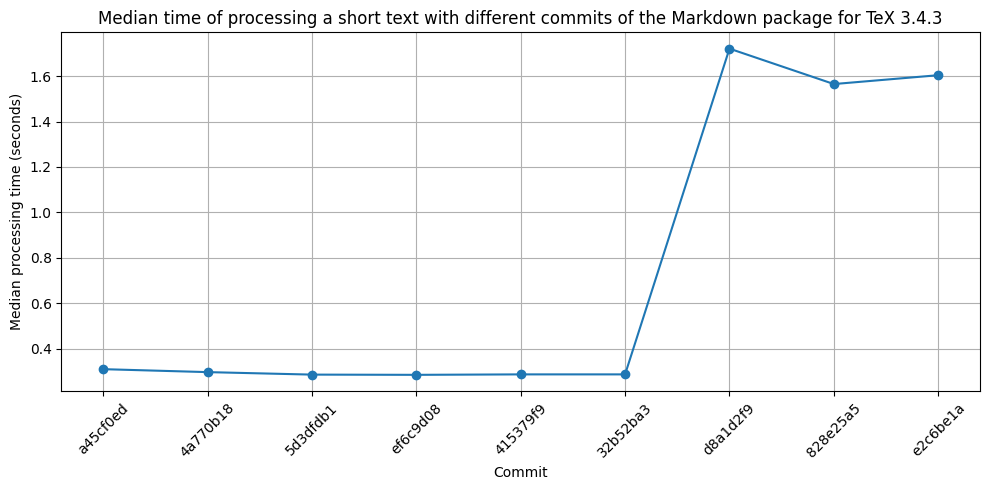

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(*zip(*durations_seconds_median.items()), marker='o', linestyle='-')
plt.title('Median time of processing a short text with different commits of the Markdown package for TeX 3.4.3')
plt.xlabel('Commit')
plt.ylabel('Median processing time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

As expected, the more than 5× slow-down is caused by PRs [#416][1], which started loading `UnicodeData.txt` and constructing a parser that recognizes all Unicode punctuation.

 [1]: https://github.com/Witiko/markdown/pull/416